In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import wget
from datasets import load_dataset

import torch 
import torch.nn as nn 
from torch.nn import functional as F

from GPT.gpt_functions import *
from Tokenizer.tokenizer_functions import *

torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

c:\Users\jean-\OneDrive\Bureau\Projects\Personnal\GPT2-Scratch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lecture 7: Let's build GPT: from scratch, in code, spelled out.

In this notebook we implement the simpliest GPT model from scratch and train it on a dataset of French poetry [https://huggingface.co/datasets/manu/french_poetry/viewer]

- 1821 poems written by 56 artists (average 32 poems per author) -> Concatenate everything in a big corpus.

In [ ]:
# import dataset: French Poetry
ds = load_dataset("manu/french_poetry")
length = ds["train"].num_rows

# Construction Corpus
df_text = []
for i in range(length):
    poem = ds["train"]["text"][i]
    cleaned_poem = poem_formatting(poem)
    df_text.append(cleaned_poem[1]) # add only the poem

corpus = "".join(df_text)
vocab_corpus = sorted(list(set(corpus)))

In [4]:
# Encoder
vocab_size = 400
tokenizer = BasicTokenizer()
tokenizer.train(corpus, vocab_size) # 400 - 256 = 144 merges happpening

# Encode data 
data = torch.tensor(tokenizer.encode(corpus), dtype = torch.long)

# Split data
n = int(0.9 * len(data))
train_data = data[:n]   # 90% training
val_data = data[n:]     # 10% evaluation

In [5]:
# Hyperparameters Model
config_GPT = GPTConfig(
    vocab_size    = vocab_size,
    block_size    = 128,
    n_embd        = 200,
    n_head        = 4,
    n_layer       = 4,
    batch_size    = 32,
    max_steps     = 1000,
    eval_iter     = 100,
    eval_interval = 10,
    learning_rate = 1e-3,
    dropout       = 0.2,
    device        ='cuda',
)

# Model
model = GPTLanguageModel(config_GPT).to(config_GPT.device)
print(f"The model has a total of {sum(p.numel() for p in model.parameters())/1e6:.2f} M parameters.")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = config_GPT.learning_rate)


The model has a total of 2.11 M parameters.


In [8]:
@torch.no_grad()
def estimate_loss(config_GPT):
    out = {}
    model.eval()
    for split, data_loss in [("train", train_data), ("val", val_data)]:

        losses = torch.zeros(config_GPT.eval_iter)
        for k in range(config_GPT.eval_iter):
            X,Y = get_batch(data_loss,config_GPT.block_size, config_GPT.batch_size, config_GPT.device)
            X, Y = X.to(config_GPT.device), Y.to(config_GPT.device)
            logits, loss = model(X,Y)
            losses[k] = loss.item()        
        out[split] = losses.mean().item()
    model.train()

    return out

In [9]:
# Training
train_loss = []
eval_loss = []

for iter in range(config_GPT.max_steps):

    # Every once in a while evaluate the loss on train and val sets
    if iter % config_GPT.eval_interval == 0 or iter == config_GPT.max_steps - 1:
        losses = estimate_loss(config_GPT)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_loss.append(losses["train"])
        eval_loss.append(losses["val"])

    # Sample a batch of data
    xb, yb = get_batch(train_data,config_GPT.block_size, config_GPT.batch_size, device = config_GPT.device)

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 6.0200, val loss 6.0184
step 10: train loss 5.0656, val loss 5.0713
step 20: train loss 4.9936, val loss 4.9922
step 30: train loss 4.9360, val loss 4.9334
step 40: train loss 4.7148, val loss 4.7047
step 50: train loss 4.5578, val loss 4.5522
step 60: train loss 4.3325, val loss 4.3256
step 70: train loss 4.1464, val loss 4.1382
step 80: train loss 4.0025, val loss 3.9885
step 90: train loss 3.9038, val loss 3.8886
step 100: train loss 3.8349, val loss 3.8239
step 110: train loss 3.7819, val loss 3.7774
step 120: train loss 3.7506, val loss 3.7428
step 130: train loss 3.7188, val loss 3.7096
step 140: train loss 3.6932, val loss 3.6894
step 150: train loss 3.6793, val loss 3.6786
step 160: train loss 3.6693, val loss 3.6666
step 170: train loss 3.6453, val loss 3.6423
step 180: train loss 3.6310, val loss 3.6381
step 190: train loss 3.6198, val loss 3.6152
step 200: train loss 3.6180, val loss 3.6120
step 210: train loss 3.6143, val loss 3.6016
step 220: train loss 

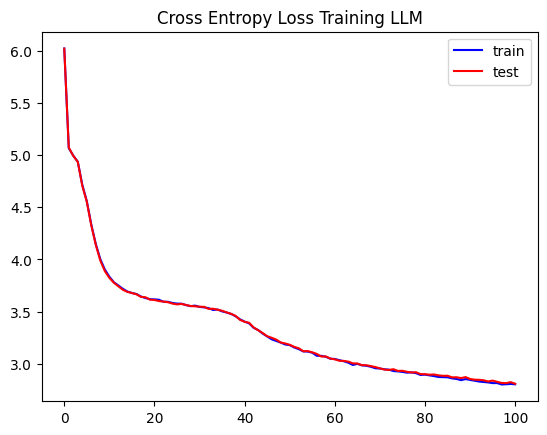

In [10]:
plt.plot(train_loss, color = "blue", label = "train")
plt.plot(eval_loss, color = "red", label = "test")
plt.legend()
plt.title("Cross Entropy Loss Training LLM")
plt.show()

In [13]:
# Inference
poemJS = "A l'aube du soir"
ids = tokenizer.encode(poemJS) # Encode poem
input_ids = torch.tensor([ids], dtype=torch.long).to(GPTConfig.device)
generate_ids = model.generate(input_ids, max_new_tokens=200)
generated_text = tokenizer.decode(generate_ids[0].tolist())
print(generated_text)


A l'aube du soir
Qu'est tout dans la trie.
Lorres désade on chah si je ne me tourri
Sans demande pu vient conmos, en larme bit tout courtix,
Elà pour chose
Crondure en on voit : je n'en baisse.
Quand il pas
Et mouriant, fille assemblait, moi,
Et que je m'esséds de venir. Ah. Une choseau core et du tyroy ! touttes de mon ains
De jette souffretir une imagandolière ambé,
Lébanle à de ton


In [15]:
# Inference
poemJS = "L'univers"
ids = tokenizer.encode(poemJS) # Encode poem
input_ids = torch.tensor([ids], dtype=torch.long).to(GPTConfig.device)
generate_ids = model.generate(input_ids, max_new_tokens=200)
generated_text = tokenizer.decode(generate_ids[0].tolist())
print(generated_text)


L'universé gres sHélas ! n'a qui parfâme
Qu'homme, je j'ai suici, bien d'odeurs
Le coeur et stossières en péris faste et fois en nethéant.
Ils vainque, vue et vie au fond ;
Cont un berceil es vieux, Signoir à la ficale belle-soieur de Dieu à moi, éternivrent méclies,
Sur l'anglo de regarde, veux qui, des enfant d'aignéelles en grands bleus,
Surtoutentne assion 
